## Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest

import warnings
warnings.filterwarnings('ignore')

## Read Data

In [3]:
df_train = pd.read_csv('../data/train_cleaned.csv', index_col='Id')
df_test = pd.read_csv('../data/test_cleaned.csv', index_col='Id')

## Feature Engineering

In [4]:
# Train data

# X_train = train_cleaned.drop(['SalePrice'], axis=1).copy()
# y_train = train_cleaned[['SalePrice']].copy()

# Test data

# X_test = test_cleaned.copy()

In [5]:
discrete_features = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
           'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars',
            'Mo Sold', 'Yr Sold']

continuous_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
                       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
                       'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

nominal_features = ['PID', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
                    'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
                    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating',
                    'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type']

ordinal_features = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual',
                    'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
                    'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
                    'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence'
                   ]

**Age of House**

In [6]:
df_train['Age'] = df_train['Yr Sold'] - df_train['Year Built']
df_test['Age'] = df_test['Yr Sold'] - df_test['Year Built']

In [7]:
discrete_features.remove('Yr Sold')
discrete_features.remove('Year Built')
discrete_features.remove('Year Remod/Add')

In [8]:
discrete_features.append('Age')

**Township of House**  
Reference: http://www.storycountyiowa.gov/Faq.aspx?QID=169

In [9]:
df_train['Township'] = df_train['PID'].apply(lambda x: str(x)[:3])
df_test['Township'] = df_test['PID'].apply(lambda x: str(x)[:3])

In [10]:
nominal_features.remove('PID')

In [11]:
nominal_features.append('Township')

**Total SF**

In [12]:
df_train['Total SF'] = df_train[['Total Bsmt SF', '1st Flr SF', '2nd Flr SF']].sum(axis=1)
df_test['Total SF'] = df_test[['Total Bsmt SF', '1st Flr SF', '2nd Flr SF']].sum(axis=1)

In [13]:
continuous_features.remove('Total Bsmt SF')
continuous_features.remove('1st Flr SF')
continuous_features.remove('2nd Flr SF')

In [14]:
continuous_features.append('Total SF')

**Explore discrete, continuous, and ordinal variables with high correlation with SalePrice**

In [15]:
subset_features_and_target = discrete_features + continuous_features + ordinal_features + ['SalePrice']

In [16]:
# subset_features = continuous_features + ['SalePrice']

In [17]:
# df_train = pd.concat([X_train, y_train], axis=1)

In [18]:
df_train[subset_features_and_target].corr()['SalePrice'].sort_values(ascending=False)

SalePrice          1.000000
Total SF           0.830979
Overall Qual       0.803276
Gr Liv Area        0.721925
Exter Qual         0.714759
Kitchen Qual       0.693022
Garage Area        0.653894
Garage Cars        0.647460
Bsmt Qual          0.616228
Garage Finish      0.559005
Full Bath          0.538732
Fireplace Qu       0.537845
Mas Vnr Area       0.520501
TotRms AbvGrd      0.511007
Fireplaces         0.473933
Heating QC         0.458679
BsmtFin SF 1       0.446922
Bsmt Exposure      0.427511
BsmtFin Type 1     0.353104
Lot Frontage       0.350892
Open Porch SF      0.330726
Wood Deck SF       0.329865
Lot Area           0.303137
Paved Drive        0.290136
Bsmt Full Bath     0.285615
Garage Qual        0.285459
Half Bath          0.278854
Garage Cond        0.264949
Garage Yr Blt      0.258078
Electrical         0.246662
Bsmt Cond          0.224596
Bsmt Unf SF        0.191294
Bedroom AbvGr      0.138419
Pool Area          0.137777
Screen Porch       0.137777
Functional         0

In [19]:
mask_corr = (df_train[subset_features_and_target].corr()['SalePrice'].abs() > 0.5) & (df_train[subset_features_and_target].corr()['SalePrice'].abs() != 1)
df_train[subset_features_and_target].corr()['SalePrice'][mask_corr]

Full Bath        0.538732
TotRms AbvGrd    0.511007
Garage Cars      0.647460
Age             -0.572322
Mas Vnr Area     0.520501
Gr Liv Area      0.721925
Garage Area      0.653894
Total SF         0.830979
Overall Qual     0.803276
Exter Qual       0.714759
Bsmt Qual        0.616228
Kitchen Qual     0.693022
Fireplace Qu     0.537845
Garage Finish    0.559005
Name: SalePrice, dtype: float64

In [20]:
chosen_numeric_and_ordinal_features = df_train[subset_features_and_target].corr()['SalePrice'][mask_corr].index.tolist()
chosen_numeric_and_ordinal_features

['Full Bath',
 'TotRms AbvGrd',
 'Garage Cars',
 'Age',
 'Mas Vnr Area',
 'Gr Liv Area',
 'Garage Area',
 'Total SF',
 'Overall Qual',
 'Exter Qual',
 'Bsmt Qual',
 'Kitchen Qual',
 'Fireplace Qu',
 'Garage Finish']

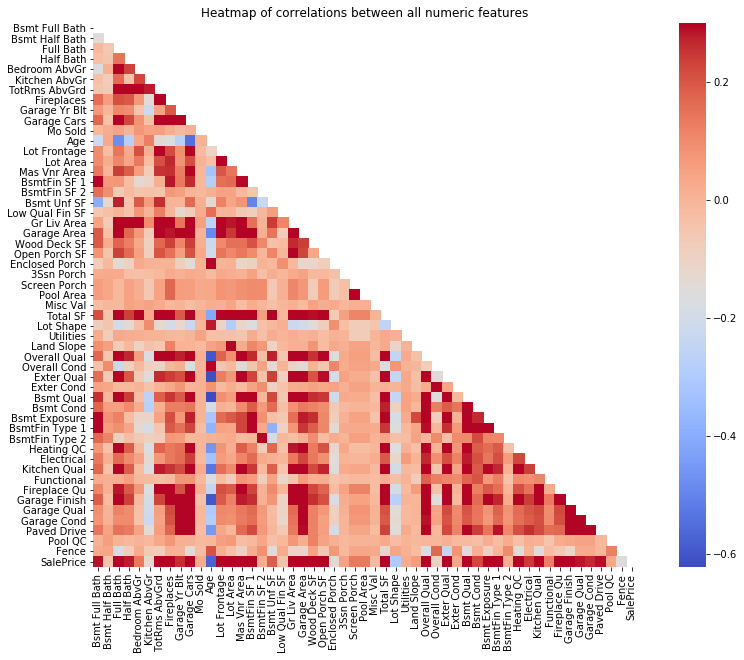

In [24]:
corr = df_train[subset_features_and_target].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap='coolwarm')
plt.title('Heatmap of correlations between all numeric features');
plt.savefig('../images/heatmap.png', transparent=True)

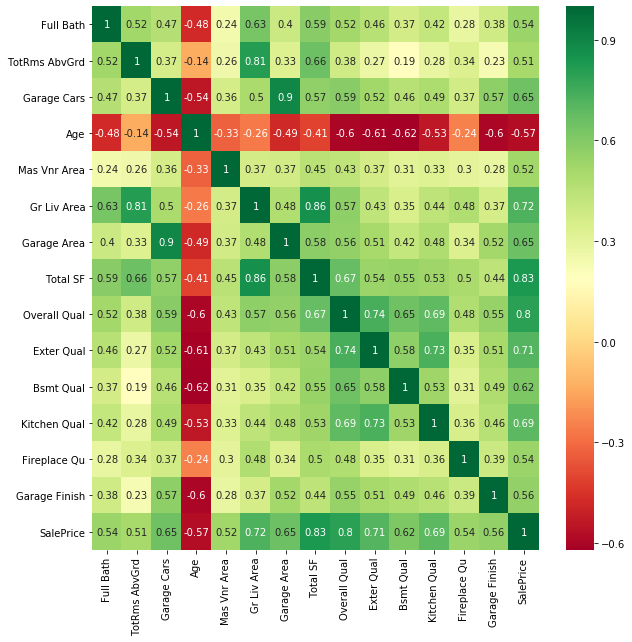

In [29]:
# most correlated features
corrmat = df_train[subset_features_and_target].corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
fig = plt.figure(figsize=(10,10))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
fig.savefig('../images/heatmap2.png', bbox_inches='tight', transparent=True)

Observation: Issue of multicollinearity arises for Age as it is correlated with all features individually.

In [22]:
chosen_numeric_and_ordinal_features.remove('Age')

**Nominal Features**

In [23]:
f_values, p_values = f_classif(df_train[nominal_features].apply(LabelEncoder().fit_transform), df_train['SalePrice'])
p_values

array([8.25167634e-001, 2.69546815e-022, 1.19968216e-209, 2.83766944e-001,
       2.16513112e-003, 7.61584934e-001, 1.69933194e-004, 7.12129414e-001,
       5.66258086e-014, 2.98620507e-001, 6.01538789e-002, 3.26550234e-003,
       6.65840166e-010, 5.80154133e-001, 4.84961562e-001, 7.42153506e-009,
       9.19574687e-023, 1.39981086e-014, 4.91551746e-017, 1.08055179e-022,
       9.98258854e-001, 6.88820466e-001, 3.36542574e-003])

In [24]:
np.where(p_values < 0.05)[0]

array([ 1,  2,  4,  6,  8, 11, 12, 15, 16, 17, 18, 19, 22])

In [25]:
df_train[nominal_features].iloc[:, np.where(p_values < 0.05)[0]].columns.tolist()

['MS Zoning',
 'Street',
 'Land Contour',
 'Neighborhood',
 'Condition 2',
 'Roof Style',
 'Roof Matl',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air',
 'Garage Type',
 'Township']

In [26]:
nominal_feature_p_value = list(zip(nominal_features, p_values))
sorted(nominal_feature_p_value, key=lambda tup: tup[1])[:8]

[('Street', 1.1996821611433728e-209),
 ('Foundation', 9.195746874974646e-23),
 ('Garage Type', 1.0805517867011127e-22),
 ('MS Zoning', 2.695468147454803e-22),
 ('Central Air', 4.9155174584387067e-17),
 ('Heating', 1.3998108621114129e-14),
 ('Condition 2', 5.662580863965296e-14),
 ('Roof Matl', 6.658401664620931e-10)]

In [27]:
chosen_nominal_features = ['Street', 'Foundation', 'Garage Type',
                           'MS Zoning', 'Central Air', 'Heating',
                           'Condition 2', 'Roof Matl']

In [28]:
X_train = df_train[chosen_numeric_and_ordinal_features + chosen_nominal_features]

In [29]:
X_test = df_test[chosen_numeric_and_ordinal_features + chosen_nominal_features]

In [30]:
y_train = df_train[['SalePrice']]

**Interaction terms**

In [31]:
# Assume that the combination of Heating and Age of the house has an effect on SalePrice
# X_train['Age * Heating'] = X_train['Age'] * X_train['Heating']
# X_test['Age * Heating'] = X_test['Age'] * X_test['Heating']

**Polynomial Features**

In [32]:
# features = ['Total SF', 'Gr Liv Area', 'Garage Area']

In [33]:
X_train['Total SF^2'] = X_train['Total SF'] ** 2
X_train['Gr Liv Area^2'] = X_train['Gr Liv Area'] ** 2
X_train['Garage Area^2'] = X_train['Garage Area'] ** 2

In [34]:
X_test['Total SF^2'] = X_test['Total SF'] ** 2
X_test['Gr Liv Area^2'] = X_test['Gr Liv Area'] ** 2
X_test['Garage Area^2'] = X_test['Garage Area'] ** 2

**Get dummies**

In [35]:
X_train = pd.get_dummies(X_train, columns=chosen_nominal_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=chosen_nominal_features, drop_first=False)

**Ensure that the number of columns in the train and test datasets are identical and in the same order**

In [36]:
def handle_unequal_train_test_columns(X_train, X_test):
    columns_not_in_test = list(set(X_train.columns).difference(set(X_test.columns)))
    for col in columns_not_in_test:
        X_test[col] = 0
        
    columns_not_in_train = list(set(X_test.columns).difference(set(X_train.columns)))
    X_test.drop(columns_not_in_train, axis=1, inplace=True)
    return X_train[sorted(X_train.columns)], X_test[sorted(X_test.columns)]

In [37]:
X_train, X_test = handle_unequal_train_test_columns(X_train, X_test)
X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [38]:
np.array_equal(X_test.columns, X_train.columns)

True

**Linear Regression**

In [39]:
linreg = LinearRegression()

In [40]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
y_train_pred = linreg.predict(X_train)

In [42]:
models_rmse = {}
models_rmse['linreg'] = (-cross_val_score(linreg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [43]:
X_test_indices = X_test.index

In [44]:
y_test_pred = linreg.predict(X_test)

In [45]:
linreg.coef_

array([[ 8.61866279e+03,  7.78721460e+03,  5.36851737e+03,
         3.84639323e+03,  5.11624158e+04,  6.18496839e+03,
        -4.90671996e+04, -2.64910632e+04,  1.30033784e+04,
         1.07002157e+04,  2.84842007e+03,  1.75809624e+03,
         4.89206652e+03,  1.86590838e+04,  1.39413735e+04,
         2.03471038e+04, -4.78158226e+03, -5.31027814e+01,
         7.87599891e-02,  3.41062549e+03,  3.53927311e+03,
         2.24863531e+04,  1.22559320e+04,  2.33762682e+04,
         1.14357622e+04,  1.78148738e+04,  1.25198680e+04,
         1.53109519e+01,  8.08476303e-04, -2.03799643e+03,
        -2.19991487e+04, -3.14414976e+04,  9.08350382e+02,
         1.27023597e+04, -1.03136496e+04,  4.10903694e+03,
         2.99098458e+04, -6.36019434e+02,  4.10490442e+03,
        -9.29565362e+03,  2.47277192e+01,  1.07225743e+04,
         6.07374534e+04,  2.97410269e+03, -3.91400195e+04,
         4.11293987e+04,  8.69492943e+03,  7.73608647e+01,
        -4.28416621e+01,  1.30515870e-02]])

In [46]:
y_test_pred = [i[0] for i in y_test_pred.tolist()]

In [47]:
def make_and_get_submissions_file(X_test_indices, y_test_pred, file_name):
    submissions = pd.DataFrame({'Id': X_test_indices, 'SalePrice': y_test_pred})
    submissions.set_index('Id', inplace=True)
    submissions.sort_index(inplace=True)
    submissions.to_csv('../data/{}.csv'.format(file_name))
    
    return submissions

In [48]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_linear_regression_feature_engineered_2')

**Standardization of features**

In [49]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

**Lasso Regression** 

In [50]:
# Cross Validation
optimal_lasso = LassoCV(n_alphas=500, cv=10) # uses 10-fold

In [51]:
# Model Fitting and Evaluation
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_train, y_train)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso_scores.mean()

0.8785261958184674

In [52]:
models_rmse['lasso'] = (-cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [53]:
y_test_pred = lasso.predict(X_test)

In [54]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_lasso_regression_feature_engineered_2')

<StemContainer object of 3 artists>

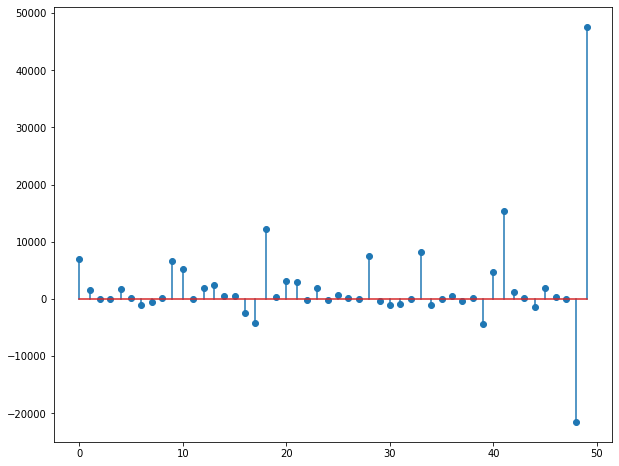

In [55]:
plt.figure(figsize=(10, 8))
plt.stem(lasso.coef_)

In [56]:
(lasso.coef_ != 0).nonzero()[0]

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49])

In [57]:
X_test_columns[(lasso.coef_ != 0).nonzero()[0]]

Index(['Bsmt Qual', 'Central Air_1', 'Condition 2_Feedr', 'Condition 2_PosA',
       'Condition 2_PosN', 'Condition 2_RRAe', 'Condition 2_RRAn',
       'Condition 2_RRNn', 'Exter Qual', 'Fireplace Qu', 'Foundation_PConc',
       'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'Full Bath',
       'Garage Area', 'Garage Area^2', 'Garage Cars', 'Garage Finish',
       'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn',
       'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_None',
       'Gr Liv Area^2', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW',
       'Heating_Wall', 'Kitchen Qual', 'MS Zoning_C (all)',
       'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM',
       'Mas Vnr Area', 'Overall Qual', 'Roof Matl_Membran',
       'Roof Matl_Tar&Grv', 'Roof Matl_WdShake', 'Roof Matl_WdShngl',
       'Street_Pave', 'Total SF', 'Total SF^2'],
      dtype='object')

In [58]:
lasso.coef_[(lasso.coef_ != 0).nonzero()[0]]

array([ 7.06695556e+03,  1.65913521e+03,  3.88369348e+00,  1.69213077e+03,
        1.40953132e+02, -1.08503519e+03, -5.96413649e+02,  1.58926080e+02,
        6.61390152e+03,  5.23075233e+03,  1.96439462e+03,  2.51077929e+03,
        5.24013034e+02,  4.73862696e+02, -2.38278415e+03, -4.21256077e+03,
        1.22631686e+04,  3.43827486e+02,  3.12966017e+03,  3.02068930e+03,
       -2.07607724e+02,  1.97725330e+03, -1.79687047e+02,  7.04775515e+02,
        1.43326128e+02,  7.46024894e+03, -3.83574275e+02, -1.03358387e+03,
       -9.53598249e+02,  3.70878275e+01,  8.26018769e+03, -1.13622321e+03,
        5.65293059e+02, -4.15893775e+02,  2.13267658e+02, -4.29839324e+03,
        4.64870249e+03,  1.53819568e+04,  1.25173191e+03,  1.33133204e+02,
       -1.46824887e+03,  1.95848597e+03,  3.74263084e+02, -2.15190135e+04,
        4.76254906e+04])

In [59]:
lasso.coef_

array([ 7.06695556e+03,  1.65913521e+03,  3.88369348e+00, -0.00000000e+00,
        1.69213077e+03,  1.40953132e+02, -1.08503519e+03, -5.96413649e+02,
        1.58926080e+02,  6.61390152e+03,  5.23075233e+03,  0.00000000e+00,
        1.96439462e+03,  2.51077929e+03,  5.24013034e+02,  4.73862696e+02,
       -2.38278415e+03, -4.21256077e+03,  1.22631686e+04,  3.43827486e+02,
        3.12966017e+03,  3.02068930e+03, -2.07607724e+02,  1.97725330e+03,
       -1.79687047e+02,  7.04775515e+02,  1.43326128e+02,  0.00000000e+00,
        7.46024894e+03, -3.83574275e+02, -1.03358387e+03, -9.53598249e+02,
        3.70878275e+01,  8.26018769e+03, -1.13622321e+03,  0.00000000e+00,
        5.65293059e+02, -4.15893775e+02,  2.13267658e+02, -4.29839324e+03,
        4.64870249e+03,  1.53819568e+04,  1.25173191e+03,  1.33133204e+02,
       -1.46824887e+03,  1.95848597e+03,  3.74263084e+02,  0.00000000e+00,
       -2.15190135e+04,  4.76254906e+04])

In [60]:
lasso_df = pd.DataFrame({'feature': X_test_columns, 'coefficient': lasso.coef_})

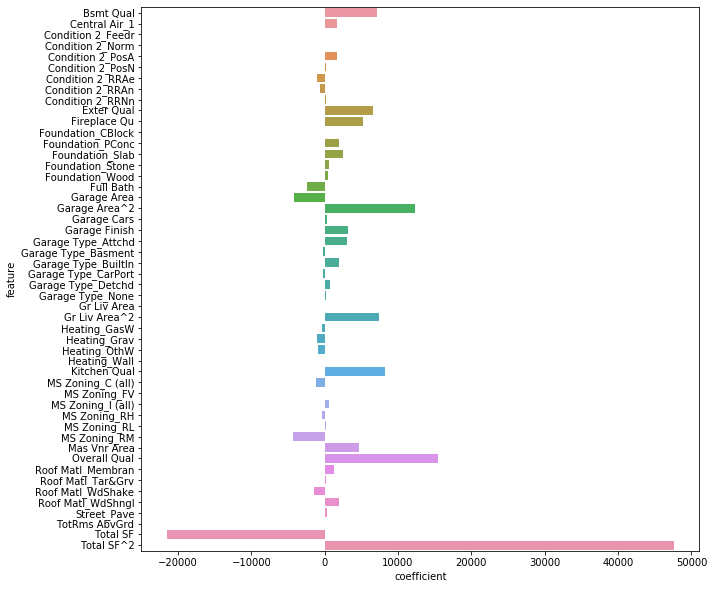

In [61]:
plt.figure(figsize=(10,10))
# coefs = lasso.coef_
# plt.barh(np.arange(coefs.size), coefs)
# plt.yticks(np.arange(coefs.size), X_test_columns)
# plt.title("Sparse coefficients")
# plt.tight_layout()

sns.barplot(x="coefficient", y="feature", data=lasso_df)

**Ridge Regression**

In [62]:
# Cross Validation
optimal_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

In [63]:
# Model Fitting and Evaluation
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train, y_train)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge_scores.mean()

0.8778769270053344

In [64]:
models_rmse['ridge'] = (-cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [65]:
y_test_pred = ridge.predict(X_test)

In [66]:
y_test_pred = y_test_pred.reshape(-1)

In [67]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_ridge_regression_feature_engineered_2')

**Elastic Net Regression**

In [68]:
optimal_enet = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10,
                            verbose=1)

In [69]:
optimal_enet.fit(X_train, y_train)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet.fit(X_train, y_train)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)
np.mean(enet_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.8785205389992532

In [70]:
models_rmse['enet'] = (-cross_val_score(enet, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [71]:
y_test_pred = enet.predict(X_test)

In [72]:
y_test_pred = y_test_pred.reshape(-1)

In [73]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_enet_regression_feature_engineered_2')

In [74]:
models_rmse

{'linreg': 27539.72944402934,
 'lasso': 27394.4281547934,
 'ridge': 27464.229081607868,
 'enet': 27394.47469610519}

Lasso Regression was chosen as its RMSE value was the lowest.